<a href="https://colab.research.google.com/github/mknomics/tradewars/blob/LSTM/Prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Towards a causal ML model (In Development)

This code is not yet complete.  Currently I am working on a single file in the data repository.  Using a LSTM framework, I predict the time series of US imports of Chinese Goods at the product level.  

Note: Need to explore options to speed training and parameter value search up



In [96]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 
import zipfile
import time
#within module imports
from numpy import array
from numpy import hstack

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import CuDNNLSTM
from keras.preprocessing.sequence import TimeseriesGenerator
from keras import metrics
from keras.optimizers import SGD

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

from sklearn.preprocessing import MinMaxScaler
    

url_names = 'https://raw.githubusercontent.com/mknomics/tradewars/master/pid.csv'
df_names = pd.read_csv(url_names)


#url = 'https://raw.githubusercontent.com/mknomics/tradewars/master/final'+str(df_names['pid'][ind])+'.csv'
url = 'https://raw.githubusercontent.com/mknomics/tradewars/master/final1268.csv'
df = pd.read_csv(url)
#df.head()
#first row has N/A values - drop this row
#print(df.isna().sum())
df = df.drop(index=0)
period = df['period']
linear_x=df['x'].values
df = df.drop(columns=['x', 'T', 'r2', 's', 'sf', '_merge','period','HS7','pid','month', '_Imonth_2', '_Imonth_3', '_Imonth_4', '_Imonth_5', '_Imonth_6', '_Imonth_7', '_Imonth_8', '_Imonth_9', '_Imonth_10', '_Imonth_11', '_Imonth_12'])

#define X and Y sets
X = df.iloc[:,1:].values
Y = df.iloc[:,0].values
Y = np.reshape(Y, (Y.shape[0],1))
linear_x = np.reshape(linear_x, (linear_x.shape[0], 1))


def scale_data(X,Y, linear_x):
    #scale X and Y
    X_scaler = MinMaxScaler(feature_range=(0,1))
    Y_scaler = MinMaxScaler(feature_range=(0,1))
    x_scaler = MinMaxScaler(feature_range=(0,1))
    scaled_X = pd.DataFrame(X_scaler.fit_transform(X))
    scaled_Y = pd.DataFrame(Y_scaler.fit_transform(Y))
    scaled_linear = pd.DataFrame(x_scaler.fit_transform(linear_x))
    return scaled_X, scaled_Y, scaled_linear

scaled_X, scaled_Y, scaled_linear = scale_data(X,Y, linear_x)
timesteps = 6



def timesplit(scaled_X, scaled_Y, timesteps=True):
    '''
    splits data into sets that can accommodate a windowsize = timesteps
    '''
    #define pre-treatment period
    X_pre = scaled_X.iloc[:90,:].values
    Y_pre = scaled_Y.iloc[:90,:].values

    #define training sets
    X_train = X_pre[0:-(timesteps+2),:]
    Y_train = Y_pre[0:-(timesteps+2),:]

    #define validation sets
    X_validate = X_pre[-(timesteps+1):,:]
    Y_validate = Y_pre[-(timesteps+1):,:]

    #define test set, note that test set cannot be used with a data generator and a window = 12
    #X_test_scaled = X_train.iloc[91:99,:]
    #Y_test_scaled = Y_train.iloc[:,0]

    '''
    After hyperparameter optimization, I want to then fit the model on both sets
    '''
    #Fit set = train + validate
    Y_fit = np.concatenate((Y_train, Y_validate), axis=0)
    X_fit = np.concatenate((X_train, X_validate), axis=0)

    return X_pre, Y_pre, X_train, Y_train, X_validate, Y_validate, X_fit, Y_fit


X_pre, Y_pre, X_train, Y_train, X_validate, Y_validate, X_fit, Y_fit = timesplit(scaled_X, scaled_Y, timesteps=timesteps)

n_features = X_fit.shape[1]

print("X_train shape", X_train.shape, "X_validate shape:", X_validate.shape, "X_fit shape:", X_fit.shape, "X shape:", X.shape)
print("Y_train shape", Y_train.shape, "Y_validate shape:", Y_validate.shape, "Y_fit shape", Y_fit.shape, "Y shape", Y.shape)

timesteps=12
def make_generators(timesteps, X_train, Y_train, X_validate, Y_validate, X_fit, Y_fit):
    #Create training and validtion generators
    train_generator = TimeseriesGenerator(data=X_train, 
                                          targets=Y_train, 
                                          length=timesteps, 
                                          batch_size=timesteps)
    validation_generator = TimeseriesGenerator(data=X_validate, 
                                               targets=Y_validate, 
                                               length=timesteps, 
                                               batch_size=timesteps)
    #after model selection then fit on training + validation data
    fit_generator = TimeseriesGenerator(data=X_fit, 
                                        targets=Y_fit, 
                                        length=timesteps, 
                                        batch_size=timesteps)
    return train_generator, validation_generator, fit_generator


def objective(space):
    '''#define a model for hyperparameter optimization, then take those optimal 
    values to define our optimal model.  Some computation is wasted here and this 
    can be improved on, but right now I am still prototyping the model.'''

    timesteps = space['timesteps']
    print(timesteps)
    X_pre, Y_pre, X_train, Y_train, X_validate, Y_validate, X_fit, Y_fit = timesplit(scaled_X, scaled_Y, timesteps=timesteps)
    train_generator, validation_generator, fit_generator = make_generators(timesteps, X_train, Y_train, X_validate, Y_validate, X_fit, Y_fit)

    #prediction model for post treatment
    #full_generator = TimeseriesGenerator(data=X, targets=Y, length=timesteps, batch_size=timesteps)

    def lstm_model(nodes=n_features, 
                    timesteps=timesteps):
        #make model
        model = Sequential()

        model.add(LSTM(nodes, 
                      input_shape=(timesteps, n_features), 
                      activation="relu", 
                      return_sequences=True))   
        model.add(Dropout(space['dropout']))
        if space['layers']!=2:
            model.add(LSTM(nodes, 
                          input_shape=(timesteps, n_features), 
                          activation="relu", 
                          return_sequences=True))   
            model.add(Dropout(space['dropout']))          
        elif space['layers']==3:
            model.add(LSTM(nodes, 
                          input_shape=(timesteps, n_features), 
                          activation="relu", 
                          return_sequences=True))   
            model.add(Dropout(space['dropout']))
        model.add(Flatten())
        model.add(Dense(timesteps))
        model.add(Dense(1)) 

        model.compile(loss='mean_squared_error', 
                      optimizer='adam', 
                      metrics=['mean_squared_error'])
        return model

    model = lstm_model(nodes=n_features, timesteps=timesteps)

    # fit model
    train_history = model.fit_generator(train_generator, 
                                        validation_data=validation_generator, 
                                        steps_per_epoch=1, 
                                        epochs=space['epochs'], 
                                        verbose=0)  
    
    return {'loss': train_history.history['val_loss'][-1] , 'status': STATUS_OK}

epoch_space = [20, 200, 400]
timestep_space = [6, 12]
layers_space = [1, 2, 3]

space = {'epochs': hp.choice('p_epochs', epoch_space),
         'dropout': hp.uniform('p_dropout', 0.1, 0.5),
         'timesteps': hp.choice('p_timesteps', timestep_space),
         'layers': hp.choice('p_layers', layers_space)}

trials = Trials()     
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)  
  
dropout = trials.best_trial['misc']['vals']['p_dropout'][0]
epochs = epoch_space[trials.best_trial['misc']['vals']['p_epochs'][0]]
timesteps = timestep_space[trials.best_trial['misc']['vals']['p_timesteps'][0]]
layers = layers_space[trials.best_trial['misc']['vals']['p_layers'][0]]
print("dropout:", dropout, "epochs:", epochs, "timesteps", timesteps, "layers", layers)



X_train shape (82, 95) X_validate shape: (7, 95) X_fit shape: (89, 95) X shape: (107, 95)
Y_train shape (82, 1) Y_validate shape: (7, 1) Y_fit shape (89, 1) Y shape (107, 1)
12
12
6
12
6
12
12
12
6
6
100%|██████████| 10/10 [08:09<00:00, 55.63s/it, best loss: 0.0007720949943177402]
dropout: 0.12098429619536755 epochs: 400 timesteps 6 layers 3


# Now train an optimal model

In [0]:
def lstm_opt_model(nodes=n_features, timesteps=timesteps, layers=layers, dropout=dropout):
    #make model
    model = Sequential()

    model.add(LSTM(nodes, 
                  input_shape=(timesteps, n_features), 
                  activation="relu", 
                  return_sequences=True))   
    model.add(Dropout(dropout))

    if layers!=2:
        model.add(LSTM(nodes, 
                      input_shape=(timesteps, n_features), 
                      activation="relu", 
                      return_sequences=True))   
        model.add(Dropout(dropout))        
    elif layers==3:
        model.add(LSTM(nodes, 
                      input_shape=(timesteps, n_features), 
                      activation="relu", 
                      return_sequences=True))   
        model.add(Dropout(dropout))

    model.add(Flatten())
    model.add(Dense(timesteps))
    model.add(Dense(1)) 

    model.compile(loss='mean_squared_error', 
                  optimizer='adam', 
                  metrics=['mean_squared_error'])
    return model



X_pre, Y_pre, X_train, Y_train, X_validate, Y_validate, X_fit, Y_fit = timesplit(scaled_X, scaled_Y, timesteps=timesteps)
train_generator, validation_generator, fit_generator = make_generators(timesteps, X_train, Y_train, X_validate, Y_validate, X_fit, Y_fit)

model = lstm_opt_model(nodes=n_features, timesteps=timesteps)

# fit model
train_history = model.fit_generator(train_generator, validation_data=validation_generator, epochs=epochs, verbose=0)  



# Plot Loss Curves and also Time Series Predictions vs. Actual to make a visual evaluation.

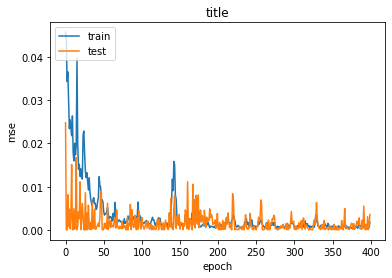

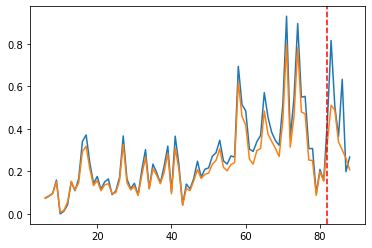

In [98]:
# summarize history for loss
def plot_loss(train_history=train_history, title='model loss'):
    plt.plot(train_history.history['mean_squared_error'])
    plt.plot(train_history.history['val_mean_squared_error'])
    plt.title('title')
    plt.ylabel('mse')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    return plt.show()

#plot predictions vs actual
def plot_pred_actual(fit_generator, Y_fit, X_train):
    yhat_val = model.predict_generator(generator=fit_generator)
    dt = 1
    t = np.arange(0, yhat_val.shape[0], dt)
    #scale t accordingly, since first values are not used
    t = t+timesteps
    plt.plot(t, Y_fit[timesteps:, :], t, yhat_val)
    plt.axvline(x=(X_train.shape[0]), color='red', linestyle='--')
    return plt.show()
plot_loss(train_history=train_history, title='model loss: timesteps=6')

plot_pred_actual(fit_generator, Y_fit, X_train)

# Red Dash splits training/val sets: Model still seems to be overfit even after minimizing validation loss
Solutions

1) adjust the hyperparameter space, make a bigger grid, add other parameters?

2) Add regularization

3) create my own definition of loss.  Can I minimize a weighted 2D space instead of a single metric?  Perhaps adding another dimension such as:

{max[abs(validation error)] - max[abs(prediction error in last batch)]} 

4) Rolling windows and cross validation.  Could this type of model perform better?


# Scrap Code Below

In [99]:
breakithere
# summarize history for loss
def plot_loss(train_history=train_history, title='model loss'):
    plt.plot(train_history.history['mean_squared_error'])
    plt.plot(train_history.history['val_mean_squared_error'])
    plt.title('title')
    plt.ylabel('mse')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    return plt.show()

#plot predictions vs actual
def plot_pred_actual(fit_generator, Y_fit, X_train):
    yhat_val = model.predict_generator(generator=fit_generator)
    dt = 1
    t = np.arange(0, yhat_val.shape[0], dt)
    #scale t accordingly, since first values are not used
    t = t+timesteps
    plt.plot(t, Y_fit[timesteps:, :], t, yhat_val)
    plt.axvline(x=(X_train.shape[0]), color='red', linestyle='--')
    return plt.show()

# summarize history for loss
plot_loss(train_history=train_history, title='model loss: timesteps=6')

#predict for the full set

scaled_X = scaled_X.values
scaled_Y = scaled_Y.values


full_generator = TimeseriesGenerator(data=scaled_X, targets=scaled_Y, length=timesteps, batch_size=timesteps)

yhat_full = model.predict_generator(generator=full_generator)
dt = 1
t = np.arange(0, yhat_full.shape[0], dt)
#scale t accordingly, since first values are not used
t = t+timesteps
plt.plot(t, scaled_Y[timesteps:, :], t, yhat_full)
plt.axvline(x=91, color='red', linestyle='--')
plt.axvline(x=X_train.shape[0], color='green', linestyle='--')
plt.show()

from google.colab import files
plt.plot(t, scaled_Y[timesteps:, :], 'k-', t, yhat_full, 'r-')
plt.axvline(x=91, color='red', linestyle='--')
plt.axvline(x=X_train.shape[0], color='green', linestyle='--')
plt.suptitle(['pid'+str(pid)])
plt.show()

plt.savefig("abc"+str(pid)+".png")

time.sleep(5)
files.download("abc"+str(pid)+".png") 

NameError: ignored